# Final pipeline for EfficientNet_B0

Set up device agnoitic code

In [22]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Regular imports

In [23]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

## Set up path to Data

In [24]:
import os
import zipfile

from pathlib import Path

import requests

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "Animal-spectogram2"

if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")


data\Animal-spectogram2 directory exists.


Set up dirs

In [25]:
# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

## Create Dataset and DataLoaders

### Creating transforms for our model

We must follow the weights that are mentioned and are required for our chosen model, `efficientnet_b0` from `torchvision.models`

Hence, for the `efficientnet_b0` we will take `EfficientNet_B0_Weights.DEFAULT`

In [26]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

## Data Preprocess (According to model `efficientnet_b0`)

Now, we will use the predefined transforms associated with `EfficientNet_B0_Weights.DEFAULT` to preprocess our data using the `transforms()` method

In [27]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

## Create Dataset

Convert our image data into a dataset (tensors) that can be accessed and understood by our model

In [28]:
train_data = datasets.ImageFolder(train_dir, transform=auto_transforms)
test_data = datasets.ImageFolder(test_dir, transform=auto_transforms)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 2240
     Root location: data\Animal-spectogram2\train
     StandardTransform
 Transform: ImageClassification(
                crop_size=[224]
                resize_size=[256]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BICUBIC
            ),
 Dataset ImageFolder
     Number of datapoints: 560
     Root location: data\Animal-spectogram2\test
     StandardTransform
 Transform: ImageClassification(
                crop_size=[224]
                resize_size=[256]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BICUBIC
            ))

## Create DataLoaders


To make our dataset iterable

In [29]:
# Create training and testing DataLoaders as well as get a list of class names
BATCH_SIZE = 32

train_dataloader = DataLoader(
      dataset=train_data,
      batch_size=BATCH_SIZE,
      shuffle=True,
      num_workers=os.cpu_count(),
)
test_dataloader = DataLoader(
      dataset=test_data,
      batch_size=BATCH_SIZE,
      shuffle=False, # don't need to shuffle test data
      num_workers=os.cpu_count(),
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x230328f47c0>,
 <torch.utils.data.dataloader.DataLoader at 0x230783ba760>)

## Getting a pre-trained model (`efficientnet_b0`)

In [30]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT 
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

### Classical Model summary

In [31]:
from torchinfo import summary

summary(model=model, 
        input_size=(BATCH_SIZE, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
) 

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

### Augmenting `model` to meet our requirements

In [32]:
# Freeze all layers except the final head (optional but recommended for fine-tuning)
for param in model.parameters():
    param.requires_grad = False

# Set the manual seeds
torch.manual_seed(42) # To maintain same output
torch.cuda.manual_seed(42)

num_classes = len(train_data.classes)

# Replace the final classification head for your 18 classes
num_ftrs = model.classifier[1].in_features  
model.classifier[1] = nn.Linear(num_ftrs, num_classes)

### Augmented model summary

In [33]:
summary(model, 
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 10]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## Train and Evaluate model

In [34]:
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True'

### train step module

Defines the training loop 

In [35]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metrics across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

### test step module

Defines the testing loop

In [36]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
    
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

### `train()` to combine both the train step and test step in one go

In [37]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 25):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        # Ensure all data is moved to CPU and converted to float for storage
        results["train_loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
        results["train_acc"].append(train_acc.item() if isinstance(train_acc, torch.Tensor) else train_acc)
        results["test_loss"].append(test_loss.item() if isinstance(test_loss, torch.Tensor) else test_loss)
        results["test_acc"].append(test_acc.item() if isinstance(test_acc, torch.Tensor) else test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

### Finally pass `model` through the `train()` to train the model and evaluate it

In [38]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 25

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_results = train(model=model, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.9276 | train_acc: 0.3772 | test_loss: 1.6567 | test_acc: 0.4497
Epoch: 2 | train_loss: 1.5739 | train_acc: 0.4795 | test_loss: 1.4878 | test_acc: 0.4983
Epoch: 3 | train_loss: 1.4473 | train_acc: 0.5304 | test_loss: 1.4234 | test_acc: 0.5347
Epoch: 4 | train_loss: 1.3768 | train_acc: 0.5384 | test_loss: 1.3872 | test_acc: 0.5243
Epoch: 5 | train_loss: 1.3119 | train_acc: 0.5723 | test_loss: 1.3683 | test_acc: 0.5347
Epoch: 6 | train_loss: 1.2514 | train_acc: 0.5960 | test_loss: 1.3645 | test_acc: 0.5191
Epoch: 7 | train_loss: 1.2194 | train_acc: 0.5973 | test_loss: 1.3301 | test_acc: 0.5451
Epoch: 8 | train_loss: 1.2138 | train_acc: 0.6004 | test_loss: 1.3202 | test_acc: 0.5451
Epoch: 9 | train_loss: 1.1612 | train_acc: 0.6179 | test_loss: 1.3231 | test_acc: 0.5469
Epoch: 10 | train_loss: 1.1463 | train_acc: 0.6254 | test_loss: 1.3286 | test_acc: 0.5469
Epoch: 11 | train_loss: 1.1285 | train_acc: 0.6312 | test_loss: 1.3048 | test_acc: 0.5417
Epoch: 12 | train_l

## Plot Loss Curves

* Visualize training and testing performance over 25 epochs
* Will help in adressing any issues like overfitting or underfitting if it arises

In [39]:
# Check the model_0_results keys
model_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [40]:
from typing import Dict, List  # For type hints
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend();
    plt.savefig('B0_10Class1')

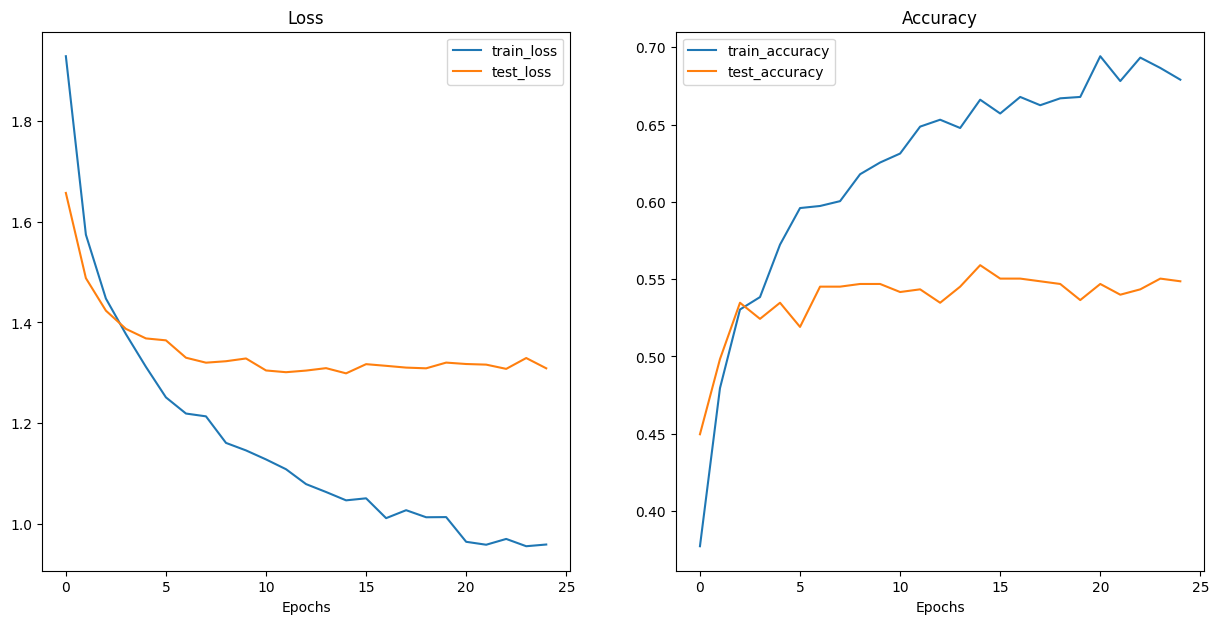

In [41]:
plot_loss_curves(model_results)

## Plot Confusion Matrix and Calculate F1 score

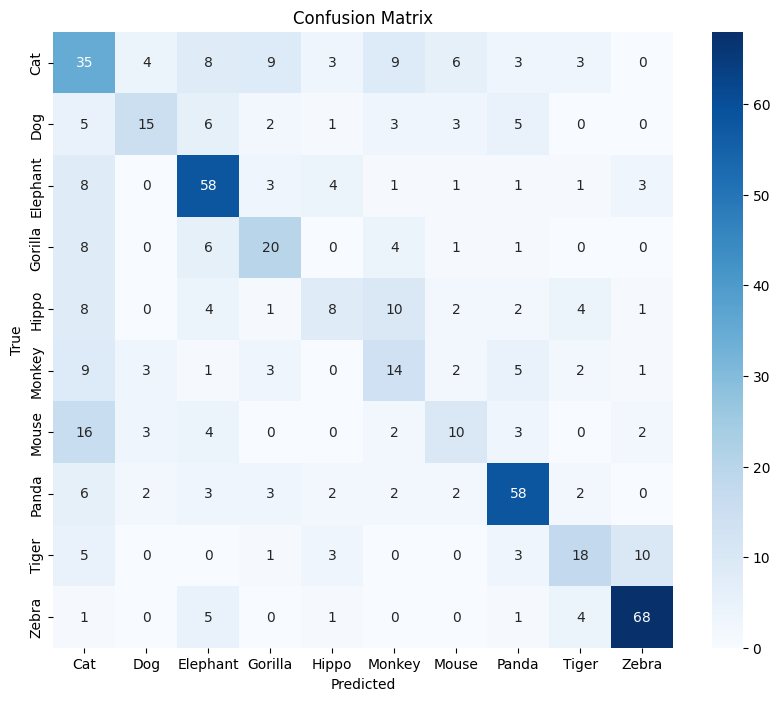

Classification Report:
              precision    recall  f1-score   support

         Cat       0.35      0.44      0.39        80
         Dog       0.56      0.38      0.45        40
    Elephant       0.61      0.72      0.66        80
     Gorilla       0.48      0.50      0.49        40
       Hippo       0.36      0.20      0.26        40
      Monkey       0.31      0.35      0.33        40
       Mouse       0.37      0.25      0.30        40
       Panda       0.71      0.72      0.72        80
       Tiger       0.53      0.45      0.49        40
       Zebra       0.80      0.85      0.82        80

    accuracy                           0.54       560
   macro avg       0.51      0.49      0.49       560
weighted avg       0.54      0.54      0.53       560

Overall F1 Score: 0.5348


<Figure size 640x480 with 0 Axes>

In [42]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
model.eval()

# Initialize lists to store true labels and predictions
true_labels = []
predictions = []

# Disable gradient computation for evaluation
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(predicted.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_data.classes, yticklabels=train_data.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
plt.savefig('B0_10Class2')

# Generate classification report which includes F1 score
print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=train_data.classes))

# Calculate and print the overall F1 score
f1 = f1_score(true_labels, predictions, average='weighted')
print(f"Overall F1 Score: {f1:.4f}")
